In [1]:
pwd

'/data/MRI/fastmri/code'

In [2]:
import glob
import h5py
import torch
from matplotlib import pyplot as plt
import numpy as np
import os
import shutil

In [4]:
def c3_multiplier_npy(shape=(320,320)):
    shp = (shape[0],shape[1])

    mul_mat=np.resize([1,-1],shp)
    
    return mul_mat * mul_mat.T


def c3_torch(shp): 
    c3m = c3_multiplier_npy(shp)
    return torch.from_numpy(np.dstack((c3m,c3m))).float()

In [6]:
shp = (360,360)
# shp = (320,320)

In [7]:
c3m = c3_torch(shp)

In [9]:
def tosquare(ksp,shp):
    rec = T.ifft2(ksp)
    sz = rec.shape
        
    return c3m * T.fft2(T.complex_center_crop(rec,shp)) * 100000

In [10]:
# # ksp = None

# datadir = '../multicoil_val/multicoil_train/'
# outdir = datadir+'/../multicoil_train2/'

# completed = []
# for fi in glob.glob(datadir+'/*.h5'):
#     with h5py.File(fi,'r') as h5:
#         print(fi)
#         volume_ksp = h5['kspace']
#         print(volume_ksp.shape,volume_ksp.dtype)
#         nslice,nch, ht, wd = volume_ksp.shape
        
#         if wd < shp[1]:
#             continue

#         for sl in range(2,nslice-2):
#             ksp = T.to_tensor(volume_ksp[sl])
#             sq = tosquare(ksp,shp)
            
#             with h5py.File('%s/%s-%.2d.h5' % (outdir,os.path.basename(fi)[:-3],sl),'w') as hw:
#                 hw['kspace']=sq.numpy()
#         completed.append(fi)
        
# for fi in completed:
#     os.unlink(fi)
# #         break        

In [30]:
from data import transforms as T

In [15]:
# torch fft requires (bat, w,h, 2)

ifft_c3 = lambda kspc3: torch.ifft(T.ifftshift(kspc3,dim=(-3,-2)),2,normalized=True)

fft_c3 = lambda im: T.fftshift(torch.fft(im,2,normalized=True),dim=(-3,-2))

In [12]:
to_cplx = lambda tor,ch: tor[ch,:,:,0].numpy()+1j*tor[ch,:,:,1].numpy()
sumsq = lambda tor: torch.sum(tor**2,dim=(0,-1))

plotksp = lambda ksp: plt.imshow(np.log(1e-2+np.abs(ksp)))
plotim = lambda im,rfunc: plt.imshow(rfunc(im),cmap='gray')
nop = lambda x: x

In [13]:
def plotch(ksp,ch):
    plt.subplot(1,3,1)
    plotksp(to_cplx(ksp,ch)*100000)
    plt.colorbar()
    if ksp.shape[-3]!=ksp.shape[-2]:
        im = T.ifft2(ksp)
    else:
        im = ifft_c3(ksp)
        
    plt.subplot(1,3,2)
    plotim(to_cplx(im,ch),np.abs)
    plt.colorbar()
    
    plt.subplot(1,3,3)
    plotim(torch.sqrt(sumsq(im)),np.abs)
#     plotim(T.root_sum_of_squares(T.complex_abs(im)),nop)
    plt.colorbar()

In [13]:
slices = glob.glob(outdir+'/*.h5')

# selslice = len(slices)//3
# ksp = None

for selslice in range(len(slices)):

    with h5py.File(slices[selslice],'r') as h5:
        ksp = torch.from_numpy(h5['kspace'][()])
        plt.figure(figsize=(12,4))
        plotch(ksp,9)

NameError: name 'outdir' is not defined

# stacking

In [14]:
# ch, ht, wd, 2
a = torch.rand((4,5,3,2))
a_re,a_im = a[:,:,:,0],a[:,:,:,1]


In [15]:
a[0,:,:,0],a[0,:,:,1]

(tensor([[0.6728, 0.3575, 0.5861],
         [0.8952, 0.9858, 0.3260],
         [0.0154, 0.1480, 0.3712],
         [0.6124, 0.9565, 0.1816],
         [0.9286, 0.5808, 0.1897]]), tensor([[0.0499, 0.1560, 0.7184],
         [0.6397, 0.7320, 0.1319],
         [0.6203, 0.5184, 0.5415],
         [0.2912, 0.1075, 0.7777],
         [0.9909, 0.3203, 0.8090]]))

In [16]:
a_re[0],a_im[0]

(tensor([[0.6728, 0.3575, 0.5861],
         [0.8952, 0.9858, 0.3260],
         [0.0154, 0.1480, 0.3712],
         [0.6124, 0.9565, 0.1816],
         [0.9286, 0.5808, 0.1897]]), tensor([[0.0499, 0.1560, 0.7184],
         [0.6397, 0.7320, 0.1319],
         [0.6203, 0.5184, 0.5415],
         [0.2912, 0.1075, 0.7777],
         [0.9909, 0.3203, 0.8090]]))

### forward (ch*2,ht,wd) with interveaved re,im in first dim

In [17]:
v1=a.permute((0,3,1,2)).reshape((-1,5,3))

In [18]:
sz=a.size

In [19]:
v1.shape

torch.Size([8, 5, 3])

In [20]:
v1[0:2,:,:]

tensor([[[0.6728, 0.3575, 0.5861],
         [0.8952, 0.9858, 0.3260],
         [0.0154, 0.1480, 0.3712],
         [0.6124, 0.9565, 0.1816],
         [0.9286, 0.5808, 0.1897]],

        [[0.0499, 0.1560, 0.7184],
         [0.6397, 0.7320, 0.1319],
         [0.6203, 0.5184, 0.5415],
         [0.2912, 0.1075, 0.7777],
         [0.9909, 0.3203, 0.8090]]])

In [21]:
v1[2:4,:,:]

tensor([[[0.1076, 0.9703, 0.2501],
         [0.1958, 0.7417, 0.8420],
         [0.5158, 0.6599, 0.9582],
         [0.8817, 0.3422, 0.6231],
         [0.7817, 0.6357, 0.5379]],

        [[0.4682, 0.6186, 0.5327],
         [0.8838, 0.2495, 0.2188],
         [0.4917, 0.8764, 0.5449],
         [0.2507, 0.9801, 0.0662],
         [0.7897, 0.3193, 0.9282]]])

In [22]:
a_re[1],a_im[1]

(tensor([[0.1076, 0.9703, 0.2501],
         [0.1958, 0.7417, 0.8420],
         [0.5158, 0.6599, 0.9582],
         [0.8817, 0.3422, 0.6231],
         [0.7817, 0.6357, 0.5379]]), tensor([[0.4682, 0.6186, 0.5327],
         [0.8838, 0.2495, 0.2188],
         [0.4917, 0.8764, 0.5449],
         [0.2507, 0.9801, 0.0662],
         [0.7897, 0.3193, 0.9282]]))

### reverse back to ch,ht,wd, 2

In [23]:
u1 = v1.reshape((-1,2,5,3)).permute((0,2,3,1))

In [24]:
u1.shape

torch.Size([4, 5, 3, 2])

In [25]:
u1[0,:,:,0]

tensor([[0.6728, 0.3575, 0.5861],
        [0.8952, 0.9858, 0.3260],
        [0.0154, 0.1480, 0.3712],
        [0.6124, 0.9565, 0.1816],
        [0.9286, 0.5808, 0.1897]])

In [26]:
a[0,:,:,0]

tensor([[0.6728, 0.3575, 0.5861],
        [0.8952, 0.9858, 0.3260],
        [0.0154, 0.1480, 0.3712],
        [0.6124, 0.9565, 0.1816],
        [0.9286, 0.5808, 0.1897]])

# dataset tests

In [37]:
from data.my_transforms import BasicMaskingTransform, ifft_c3, fft_c3
from data.mri_data import SliceData2
from common.subsample import MaskFunc2, no_masking_func, arc_masking_func
from torch.utils.data import DataLoader
import torch
from data import transforms as T

from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np

In [15]:
ncoils = 15
shp = (360,360)

In [16]:
arc_masking = MaskFunc2(arc_masking_func,ncoils,shp,4)

In [17]:
train_data = SliceData2(
    root=Path('../multicoil_val/multicoil_train2/'),
    transform=BasicMaskingTransform(arc_masking,None,None),
    sample_rate = 1,
    challenge = None)

In [18]:
len(train_data)

4394

In [19]:
samp=train_data[139]

In [20]:
[x.shape for x in samp]

[torch.Size([30, 360, 360]),
 torch.Size([30, 360, 360]),
 torch.Size([30, 360, 360]),
 torch.Size([360, 360]),
 torch.Size([360, 360])]

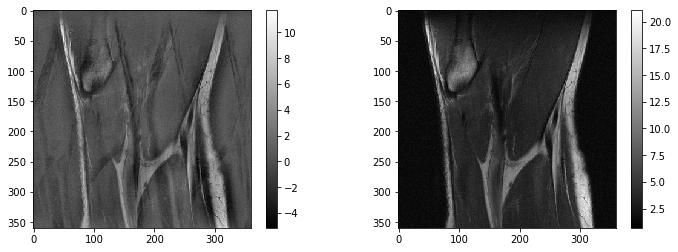

In [21]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.imshow(samp[-1]-samp[-2],cmap='gray')
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(samp[-1],cmap='gray')
plt.colorbar()


In [22]:
ksp = samp[1].reshape((-1,2,360,360)).permute((0,2,3,1))

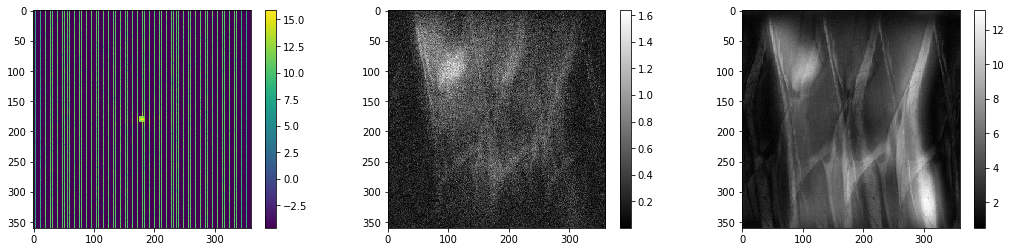

In [23]:
plt.figure(figsize=(18,4))
plotch(ksp,6)

In [24]:
msk = ~(ksp==0)

In [25]:
msk.shape

torch.Size([15, 360, 360, 2])

# Parameter repeat

In [39]:
from models.dautomap.dautomap_model import GeneralisedIFT2Layer

In [40]:
mdl = GeneralisedIFT2Layer(360,360,2)

In [46]:
mdl

GeneralisedIFT2Layer(
  (idft1): Conv2d(2, 720, kernel_size=(360, 1), stride=(1, 1), bias=False)
  (idft2): Conv2d(2, 720, kernel_size=(360, 1), stride=(1, 1), bias=False)
)

In [42]:
mdl.idft1.weight.shape

torch.Size([720, 2, 360, 1])

In [44]:
mdl2 = GeneralisedIFT2Layer(360,360,30,init_fourier=False)

In [45]:
mdl2

GeneralisedIFT2Layer(
  (idft1): Conv2d(30, 10800, kernel_size=(360, 1), stride=(1, 1), bias=False)
  (idft2): Conv2d(30, 10800, kernel_size=(360, 1), stride=(1, 1), bias=False)
)

In [47]:
mdl2.idft1.weight.shape

torch.Size([10800, 30, 360, 1])

In [48]:
tt=mdl2.idft1.weight.data[:720,:2,:,:]

In [49]:
tt.shape

torch.Size([720, 2, 360, 1])

In [55]:
for ii in range(15):
    d1 = ii*720
    d2 = ii*2
    mdl2.idft1.weight.data[d1:d1+720,d2:d2+2,:,:]=mdl.idft1.weight.data[:,:,:,:]
    mdl2.idft2.weight.data[d1:d1+720,d2:d2+2,:,:]=mdl.idft2.weight.data[:,:,:,:]

In [62]:
res=mdl2(T.ifftshift(samp[0],dim=(-2,-1) ).unsqueeze(0))

In [63]:
res.shape

torch.Size([1, 30, 360, 360])

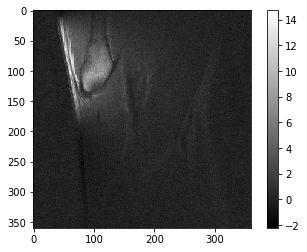

In [68]:
plt.imshow(res[0,1,:,:].detach(),cmap='gray')
plt.colorbar()

# overfitting

In [26]:
from torch.utils.data import DataLoader

In [27]:
train_loader = DataLoader(dataset=train_data, batch_size=1, shuffle=False)

In [28]:
from models.dautomap.train_domaintransform import build_model

In [29]:
from pathlib import Path
from collections import namedtuple
args = {'center_fractions':[0.08],'accelerations':[4],'challenge':'multicoil',
       'data_path':Path('../multicoil_val/multicoil_train2/'),
       'resolution':360,
       'sample_rate':0.02,
       'batch_size':1,
        'device':'cuda',
        'data_parallel':False,
        'residual':False,
        'dcblock':False,
        'in_chans':1,
        'out_chans':1,
        'num_chans':32,
        'report_interval': 100,
        'num_epochs':20,
        'num_pool_layers':4,
        'report_interval':100,
        'drop_prob':0
       }
# d_named = namedtuple("Employee", d.keys())(*d.values())

argsobj = namedtuple('args',args.keys())(*args.values())

In [30]:
mdl = build_model(argsobj)

In [31]:
mdl

GeneralisedIFT2Layer(
  (idft1): Conv2d(30, 10800, kernel_size=(360, 1), stride=(1, 1), bias=False)
  (idft2): Conv2d(30, 10800, kernel_size=(360, 1), stride=(1, 1), bias=False)
)

In [32]:
len(train_loader)

4394

In [33]:
from torch.nn import functional as F
import torch

In [34]:
from tqdm import tqdm

  0%|          | 0/20 [00:00<?, ?it/s]

1240.999267578125
6398.23974609375
212198.390625
693932.1875
16476001.0
2365643008.0
5647416.0
4879406.5
679214.0
40947616.0
26246190.0
48307092.0
8255409.5
1347694848.0
12387193856.0
236589008.0
265901712.0
55506243584.0
63613092.0
122193824.0
78338120.0
457617504.0
794478720.0
792271616.0
261876704.0
852069632.0
691009216.0
658295936.0
372214880.0
266262624.0
4802739175424.0
724347264.0
9918208000.0
215613568.0
776630336.0
2098426496.0
1116461952.0
879454080.0
1581160192.0
8865302528.0


  5%|▌         | 1/20 [17:37<5:34:59, 1057.85s/it]

1624406016.0
1941017728.0
887590336.0
823286528.0
6240830976.0
162396962816.0
29733828608.0
472480864.0
191139696.0
6451632128.0
234555072.0
2979904256.0
822666432.0
13880980480.0
177078206464.0
2272316672.0
3787637760.0
882558566400.0
1163742720.0
1412030976.0
4442594304.0
1866841728.0
883079040.0
9322864640.0
15759874048.0
2539454976.0
931554944.0
4393873408.0
698913856.0
3154262528.0
7434791813120.0
24713095168.0
18993408000.0
4854396416.0
3573966336.0
2435670528.0
7783394304.0
68686884864.0
4217974016.0
35287605248.0


 10%|█         | 2/20 [35:17<5:17:29, 1058.31s/it]

19422756864.0
3838158336.0
9404267520.0
6555138560.0
12687235072.0
126999871488.0
9483857920.0
14786402304.0
4312641024.0
7033833984.0
1303127424.0
5428786176.0
10164007936.0
78085865472.0
2246954975232.0
2770137344.0
28212557824.0
4981350989824.0
21058527232.0
2341852928.0
52101758976.0
6888158720.0
27879954432.0
47126130688.0
16618289152.0
96645390336.0
2504830464.0
19814057984.0
15669404672.0
196675551232.0
94077819289600.0
62189223936.0
58581012480.0
1440336128.0
9887763456.0
3320971008.0
3747594752.0
53330219008.0
9254073344.0
46650953728.0


 15%|█▌        | 3/20 [52:55<4:59:53, 1058.44s/it]

30161520640.0
2246234368.0
19038246912.0
17722867712.0
21357772800.0
2446748549120.0
69783740416.0
12626409472.0
686536768.0
16907962368.0
8350547968.0
7020344832.0
2357588992.0
23997474816.0
445446225920.0
8536396800.0
24476870656.0


KeyboardInterrupt: 

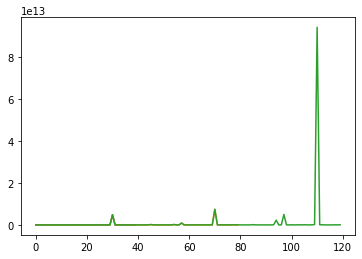

In [38]:
mdl.train()
optim = torch.optim.Adam(mdl.parameters())
v = []
for ep in tqdm(range(20)):
    for iter, data in enumerate(train_loader):
        if iter%11 == 0:
            continue

        ksp, _, im, _, _ = data
        ksp_shifted = T.ifftshift(ksp,dim=(-2,-1))
        output = mdl(ksp_shifted.cuda())
        loss = F.mse_loss(output,im.cuda(),reduction='mean')
        if iter%100==0:
            print(loss.item())
            v.append(loss.item())
        loss.backward()
        optim.step()
    plt.plot(np.array(v))

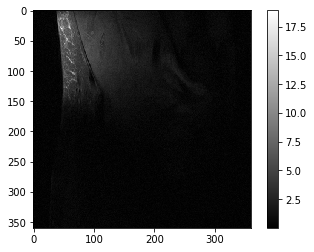

In [68]:
plt.imshow(torch.sqrt(im[0,0,:,:]**2+im[0,1,:,:]**2),cmap='gray')
plt.colorbar()